In [1]:
# Requirements.txt may be missing some packages
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, sampler, Dataset

from MatrixVectorizer import MatrixVectorizer

In [2]:
# Define file names
LR_TRAIN_DATA_FILE_NAME = "lr_train.csv"
LR_TEST_DATA_FILE_NAME = "lr_test.csv"
HR_TRAIN_DATA_FILE_NAME = "hr_train.csv"

# Define file paths
LR_TRAIN_DATA_PATH = os.path.join("data", LR_TRAIN_DATA_FILE_NAME)
LR_TEST_DATA_PATH = os.path.join("data", LR_TEST_DATA_FILE_NAME)
HR_TRAIN_DATA_PATH = os.path.join("data", HR_TRAIN_DATA_FILE_NAME)

# Load data into pandas dataframes
df_lr_train = pd.read_csv(LR_TRAIN_DATA_PATH)
df_lr_test = pd.read_csv(LR_TEST_DATA_PATH)
df_hr_train = pd.read_csv(HR_TRAIN_DATA_PATH)

# Check shapes
print(f"LR Train Shape: {df_lr_train.shape}")
print(f"LR Test Shape: {df_lr_test.shape}")
print(f"HR Train Shape: {df_hr_train.shape}")

LR Train Shape: (167, 12720)
LR Test Shape: (112, 12720)
HR Train Shape: (167, 35778)


In [3]:
print(f'LR TRAIN has {df_lr_train.isnull().sum().sum()} missing values.')  # Total missing values

LR TRAIN has 0 missing values.


In [4]:
LR_Adj_shape = 160 # Technically (160, 160) but since an adjacency matrix is always square, 160 suffices.
HR_Adj_shape = 268 # Technically (268, 268) but since an adjacency matrix is always square, 268 suffices.

LR_num_features = df_lr_train.shape[1]  # Number of features in the LR dataset
HR_num_features = df_hr_train.shape[1]  # Number of features in the HR dataset

First row of values in LR TRAIN dataset: [0.33881717 0.20248584 0.03983874 ... 0.42020538 0.25529165 0.18337431]


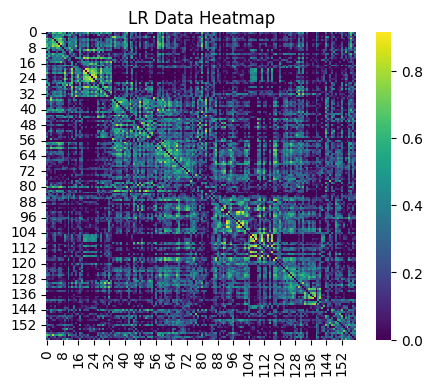

In [5]:
lr_train_sample = df_lr_train.iloc[0].values # Get first row as a numpy array
print(f'First row of values in LR TRAIN dataset: {lr_train_sample}')

# Convert the sample vector back to a matrix
lr_train_matrix_0 = MatrixVectorizer.anti_vectorize(vector = lr_train_sample, matrix_size = LR_Adj_shape, include_diagonal = False)
df_lr_train_matrix_0 = pd.DataFrame(lr_train_matrix_0)

# Plot the matrix as a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(df_lr_train_matrix_0, cmap="viridis", annot=False)
plt.title("LR Data Heatmap")
plt.show()

In [ ]:
# Simple VAE Implementation, code largely taken from my Deep Learning Coursework

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.batchnorm2 = nn.BatchNorm1d(hidden_dim // 2)
        self.layer_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.layer_logvar = nn.Linear(hidden_dim // 2, latent_dim)
        
    def forward(self, x):
        h = self.batchnorm1(torch.relu(self.layer1(x)))
        h = self.batchnorm2(torch.relu(self.layer2(h)))
        mu = self.layer_mu(h)
        logvar = self.layer_logvar(h)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, hidden_dim // 2)
        self.layer1 = nn.Linear(hidden_dim, hidden_dim)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, z):
        h = self.batchnorm1(torch.relu(self.layer1(z)))
        h = torch.relu(self.layer2(h))
        return torch.sigmoid(h)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim = LR_num_features, hidden_dim = 1024, latent_dim = 128)
        self.decoder = Decoder(latent_dim = 128, hidden_dim = 1024, output_dim = HR_num_features)
    
    def encode(self, x):
        mu, logvar = self.encoder(x)
        return mu, logvar

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z  = mu + eps * std
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In [7]:
def loss_function_VAE(recon_x, x, mu, logvar, beta = 1.0):
        mse_loss = nn.MSELoss(reduction = 'sum')     
        NLL = mse_loss(recon_x, x)
        KLD = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp())
        return NLL + beta * KLD, NLL, KLD

In [8]:
class AdjacencyMatrixDataset(Dataset):
    def __init__(self, lr_df, hr_df):
        self.lr_inputs = torch.tensor(lr_df.values, dtype=torch.float32)
        self.hr_targets = torch.tensor(hr_df.values, dtype=torch.float32)

    def __len__(self):
        return len(self.lr_inputs)

    def __getitem__(self, idx):
        return self.lr_inputs[idx], self.hr_targets[idx]

In [9]:
lr = 0.001
batch_size = 32

vae = VAE()
train_dataset = AdjacencyMatrixDataset(df_lr_train, df_hr_train)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

optimizer = torch.optim.Adam(vae.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

print(f'Total number of vae parameters: {sum(p.numel() for p in vae.parameters() if p.requires_grad)}')

X_train_tensor = torch.tensor(df_lr_train.values, dtype=torch.float32)

epochs = 20
train_losses = []
test_losses = []

for epoch in range(epochs):
    total_loss, total_NLL_loss, total_KLD_loss = 0, 0, 0
    vae.train()
    
    for data, _ in train_loader:
        optimizer.zero_grad()
        
        recon_x, mu, logvar = vae(data)
        loss, nll, kld = loss_function_VAE(recon_x, data, mu, logvar, beta)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_NLL_loss += nll.item()
        total_KLD_loss += kld.item()

    train_losses.append([total_loss / len(train_loader.dataset), total_NLL_loss / len(train_loader.dataset), total_KLD_loss / len(train_loader.dataset)])
    print(f'Epoch {epoch}: Train Loss = {train_losses[-1][0]:.2f}, NLL = {train_losses[-1][1]:.2f}, KLD = {train_losses[-1][2]:.2f}')

    total_loss, total_NLL_loss, total_KLD_loss = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for data, _ in test_loader:
            recon_x, mu, logvar = vae(data)
            loss, nll, kld = loss_function_VAE(recon_x, data, mu, logvar, beta)
            
            total_loss += loss.item()
            total_NLL_loss += nll.item()
            total_KLD_loss += kld.item()
    
    test_losses.append([total_loss / len(test_loader.dataset), total_NLL_loss / len(test_loader.dataset), total_KLD_loss / len(test_loader.dataset)])
    print(f'Epoch {epoch}: Test Loss = {test_losses[-1][0]:.2f}, NLL = {test_losses[-1][1]:.2f}, KLD = {test_losses[-1][2]:.2f}')
    
    scheduler.step()

Total number of vae parameters: 14934400


UnboundLocalError: cannot access local variable 'h' where it is not associated with a value